In [4]:
import numpy as np
from scipy import interpolate
import json
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.interpolate import griddata

In [8]:
def computeH(im1_pts, im2_pts):
    N = im1_pts.shape[0] 
    A = []
    for i in range(N):
        x, y = im1_pts[i]
        x_prime, y_prime = im2_pts[i]

        A.append([x, y, 1, 0, 0, 0, -x * x_prime, -y * x_prime, -x_prime])
        A.append([0, 0, 0, x, y, 1, -x * y_prime, -y * y_prime, y_prime])

    A = np.array(A)

    # Solve for the null space of A using SVD
    U, S, Vt = np.linalg.svd(A)
    H = Vt[-1].reshape((3, 3))

    H /= H[2, 2]

    return H

In [10]:
with open('correspondance.json', 'r') as f:
    data = json.load(f)

im1_points = np.array(data["im1Points"])
im2_points = np.array(data["im2Points"])
img1 = plt.imread('images/img1.jpg')
img2 = plt.imread('images/img2.jpg')

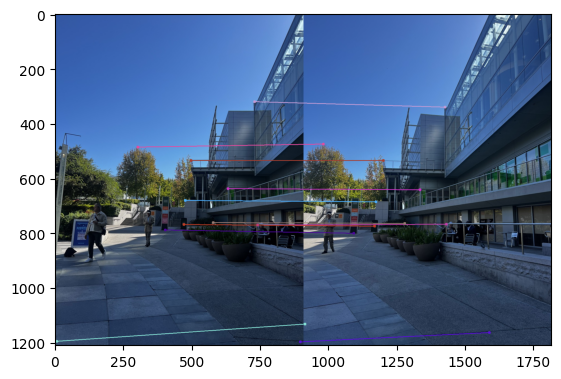

In [240]:
#draw corresponding points
combined_img = np.hstack((img1, img2))
new_points2 = im2_points.copy()
new_points2[:, 0] += img1.shape[1]
for pt1, pt2 in zip(im1_points, new_points2):
    color = tuple(np.random.randint(0, 255, 3).tolist())  # Random color for each line
    cv2.line(combined_img, tuple(pt1), tuple(pt2), color, 2)
    cv2.circle(combined_img, tuple(pt1), 5, color, -1)
    cv2.circle(combined_img, tuple(pt2), 5, color, -1)
plt.imsave('combined_correspondance.jpg', combined_img)
plt.imshow(combined_img)

In [15]:
import numpy as np
from scipy.interpolate import griddata

def warpImage(im, H):
    h, w = im.shape[:2]

    corners = np.array([
        [0, 0, 1],
        [w, 0, 1],
        [w, h, 1],
        [0, h, 1]
    ]).T

    warped_corners = H @ corners
    warped_corners /= warped_corners[2, :]  # Normalize

    x_min = int(np.floor(np.min(warped_corners[0])))
    x_max = int(np.ceil(np.max(warped_corners[0])))
    y_min = int(np.floor(np.min(warped_corners[1])))
    y_max = int(np.ceil(np.max(warped_corners[1])))
    width_warped = x_max - x_min + 1
    height_warped = y_max - y_min + 1

    x, y = np.meshgrid(np.arange(x_min, x_max + 1), np.arange(y_min, y_max + 1))
    grid_points = np.column_stack((x.flatten(), y.flatten()))

    x_src, y_src = np.meshgrid(np.arange(w), np.arange(h))
    src_points = np.column_stack((x_src.flatten(), y_src.flatten()))

    H_inv = np.linalg.inv(H)
    src_homogeneous = H_inv @ np.vstack((grid_points.T, np.ones(grid_points.shape[0])))
    src_points_warped = src_homogeneous[:2, :] / src_homogeneous[2, :]
    src_points_warped = src_points_warped.T  # Transpose here instead of earlier

    warped_image = np.zeros((height_warped, width_warped, im.shape[2]), dtype=np.float64)
    for channel in range(im.shape[2]):
        values = im[:, :, channel].flatten()
        warped_channel = griddata(
            src_points, values, src_points_warped, method='linear', fill_value=0
        )
        warped_image[:, :, channel] = warped_channel.reshape((height_warped, width_warped))

    warped_image = np.clip(warped_image, 0, 255).astype(np.uint8)

    bounding_box = ((x_min, y_min), (x_max, y_max))

    return warped_image, bounding_box

In [251]:
h, w = img1.shape[:2]
homography = computeH(im1_points, im2_points)
warpedimg, bounding_box = warpImage(img1, homography)

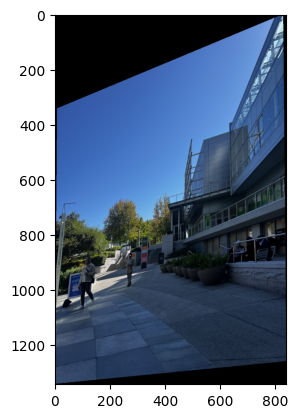

In [252]:
plt.imshow(warpedimg)

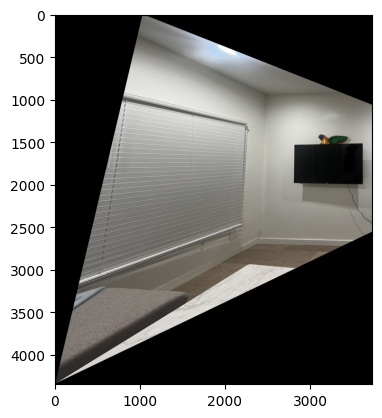

In [11]:
with open('square.json', 'r') as f:
    data = json.load(f)

im1_points = np.array(data["im2Points"])
im2_points = np.array(data["im1Points"])

homography2 = computeH(im1_points, im2_points)

img3 = plt.imread("images/img3.jpg")
warpedimg2 = warpImage(img3, homography2)
plt.imshow(warpedimg2[0])
plt.imsave("image_rectification.jpg", warpedimg2[0])

In [ ]:
with open('square.json', 'r') as f:
    data = json.load(f)

im1_points = np.array(data["im2Points"])
im2_points = np.array(data["im1Points"])

homography2 = computeH(im1_points, im2_points)

img3 = plt.imread("images/img3.jpg")
warpedimg2 = warpImage(img3, homography2)
plt.imshow(warpedimg2[0])
plt.imsave("image_rectification.jpg", warpedimg2[0])

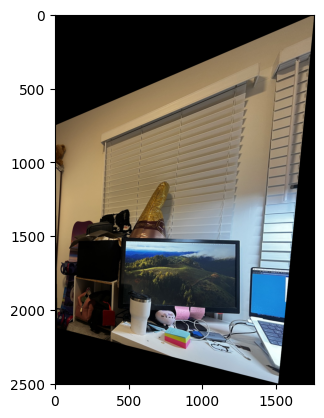

In [9]:
with open('square2.json', 'r') as f:
    data = json.load(f)

im1_points = np.array(data["im1Points"])
im2_points = np.array(data["im2Points"])

homography3 = computeH(im1_points, im2_points)

img4 = plt.imread("images/a.jpg")
warpedimg2 = warpImage(img4, homography3)
plt.imshow(warpedimg2[0])
plt.imsave("image_rectification_2.jpg", warpedimg2[0])

In [176]:
def mosaic(img1, img2, homography):
    
    warpedimg, bounding_box = warpImage(img1, homography)
    
    h1, w1 = warpedimg.shape[:2]
    h2, w2 = img2.shape[:2]
    x_shift = -bounding_box[0][0]
    y_shift = -bounding_box[0][1]
    
    res = np.zeros(((h1 + h2), (w1 + w2), 3))
    res[0:warpedimg.shape[0], 0:warpedimg.shape[1]] = warpedimg
    
    for y in range(h2):
        for x in range(w2):
            x_new, y_new = x + x_shift , y + y_shift
            res[y_new][x_new] = img2[y][x]
    
    if x_shift < 0:
        res = np.roll(res, -x_shift, axis=1)
    if y_shift < 0:
        res = np.roll(res, -y_shift, axis=0)
    
    return res.astype(np.uint8)

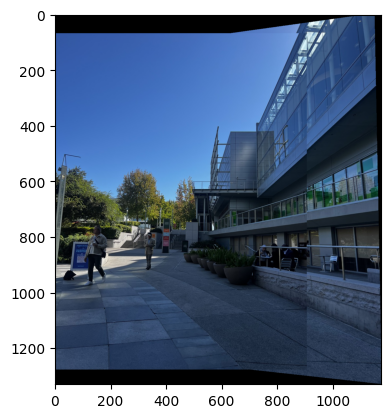

In [177]:
mosaic_image = mosaic(img1, img2, homography)
plt.imsave("merged_unsmooth.jpg", mosaic_image)
plt.imshow(mosaic_image)

In [167]:
def calculate_distance_transform(img1, img2):
    img1 = np.mean(img1, axis=2)
    img2 = np.mean(img2, axis=2)

    binary1 = img1 > np.mean(img1)
    binary2 = img2 > np.mean(img2)

    dist1 = ndimage.distance_transform_edt(binary1)
    dist2 = ndimage.distance_transform_edt(binary2)

    dist1 = (dist1 - np.min(dist1)) / (np.max(dist1) - np.min(dist1))
    dist2 = (dist2 - np.min(dist2)) / (np.max(dist2) - np.min(dist2))

    diff = np.abs(dist1 - dist2)

    return dist1, dist2, diff

In [168]:
dist1, dist2, diff = calculate_distance_transform(img1, img2)
plt.imsave("distance_trans_1.jpg", dist1, cmap = "gray")
plt.imsave("distance_trans_2.jpg", dist2, cmap = "gray")
plt.imsave("distance_trans_diff.jpg", diff, cmap = "gray")

In [16]:
def simple_blend(img1, img2, dist1, dist2, alpha=0.6, beta=0.4):
    # Ensure input images are float32
    img1 = img1.astype(np.float32)
    img2 = img2.astype(np.float32)

    # Low pass
    low_pass_img1 = cv2.GaussianBlur(img1, (5, 5), 1)
    low_pass_img2 = cv2.GaussianBlur(img2, (5, 5), 1)

    dist1_normalized = dist1 / (np.max(dist1) + 1e-6)
    dist2_normalized = dist2 / (np.max(dist2) + 1e-6)
    weights = dist1_normalized / (dist1_normalized + dist2_normalized + 1e-6)

    low_pass_blended = (weights[..., np.newaxis] * low_pass_img1 + 
                        (1 - weights[..., np.newaxis]) * low_pass_img2)

    # High pass
    high_pass_img1 = cv2.subtract(img1, low_pass_img1)
    high_pass_img2 = cv2.subtract(img2, low_pass_img2)

    high_mask = dist1 > dist2
    high_pass_blended = np.where(high_mask[..., np.newaxis], high_pass_img1, high_pass_img2)

    # Combine low and high frequency components
    final_image = cv2.addWeighted(low_pass_blended, alpha, high_pass_blended, beta, 0)
    final_image = np.clip(final_image, 0, 255).astype(np.uint8)

    return final_image

def mosaic_blend(img1, img2, homography):
    warpedimg, bounding_box = warpImage(img1, homography)
    
    h1, w1 = warpedimg.shape[:2]
    h2, w2 = img2.shape[:2]
    x_shift = -bounding_box[0][0]
    y_shift = -bounding_box[0][1]
    
    h_total = max(h1, h2 + y_shift)
    w_total = max(w1, w2 + x_shift)
    canvas1 = np.zeros((h_total, w_total, 3), dtype=np.float32)
    canvas2 = np.zeros((h_total, w_total, 3), dtype=np.float32)
    
    canvas1[0:h1, 0:w1] = warpedimg.astype(np.float32)
    
    y_start = max(0, y_shift)
    x_start = max(0, x_shift)
    canvas2[y_start:y_start+h2, x_start:x_start+w2] = img2.astype(np.float32)
    
    # Compute distance transforms
    gray1 = cv2.cvtColor(canvas1.astype(np.uint8), cv2.COLOR_RGB2GRAY)
    gray2 = cv2.cvtColor(canvas2.astype(np.uint8), cv2.COLOR_RGB2GRAY)
    _, binary1 = cv2.threshold(gray1, 1, 255, cv2.THRESH_BINARY)
    _, binary2 = cv2.threshold(gray2, 1, 255, cv2.THRESH_BINARY)
    dist1 = cv2.distanceTransform(binary1, cv2.DIST_L2, 5)
    dist2 = cv2.distanceTransform(binary2, cv2.DIST_L2, 5)
    
    dist1 = cv2.GaussianBlur(dist1, (21, 21), 5)
    dist2 = cv2.GaussianBlur(dist2, (21, 21), 5)
    
    blended = simple_blend(canvas1, canvas2, dist1, dist2)
    
    return blended
res = mosaic_blend(img1, img2, H)

In [26]:
plt.imshow(res)
plt.imsave("2_blend.png", res)

In [ ]:
with open('correspondance2.json', 'r') as f:
    data = json.load(f)

im1_points = np.array(data["im1Points"])
im2_points = np.array(data["im2Points"])
img1 = plt.imread("images/1.jpg")
img2 = plt.imread("images/2.jpg")

H, _ = computeH(im1_points, im2_points)
res = mosaic_blend(img1, img2, H)

In [34]:
plt.imshow(res2)
plt.imsave("res2.png", res2)

In [ ]:
with open('correspondance3.json', 'r') as f:
    data = json.load(f)

im1_points = np.array(data["im1Points"])
im2_points = np.array(data["im2Points"])
img1 = plt.imread("images/c.jpg")
img2 = plt.imread("images/d.jpg")
H, _ = computeH(im1_points, im2_points)
res3 = mosaic_blend(img1, img2, H)

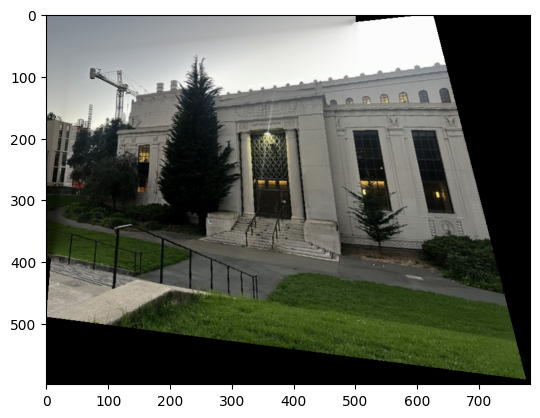

In [18]:
plt.imshow(res3)
plt.imsave("output3.png", res3)